# COGS 108 - Relationship Between Stimulus Checks and Covid Rates

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [  ] YES - make available
* [X] NO - keep private

# Overview

We wanted to find a relationship between the first two stimulus checks and positive covid rates across all the counties in California. We took the positive covid rate data of each county and ran a one sample z-test comparing the rates before and after the stimulus checks were disbersed. We found that there was a significant decrease in covid rates after the stimulus checks were given, however, this is not sufficient to conclude that there was a relationship. 

# Names

- David Em-Yinn
- Jing Li
- Anna Hsieh
- Alejandro Garcia Martinez
- Christian Gonzalez

<a id='research_question'></a>
# Research Question

*Is there a relationship between stimulus checks and covid positivity rates across the counties of California between March 2020 and February 2021?*

<a id='background'></a>

## Background & Prior Work

### INTRO:
*The Covid-19 pandemic has had a significant negative impact on the economy, with many people losing their jobs. Similar to previous recessions, the US government provided stimulus checks in hopes of boosting the economy and also assisting people with buying protective equipment, such as masks and disinfectants. In our study, we are trying to determine whether the stimulus checks have had a positive effect (negative correlation) on covid infection rates.* 

### PRIOR WORK:
*There are few studies on the effects of the government grants that relate to covid infection rates; however, there is an article about an increase in isolation and compliance due to government grants. In 2020, a survey was conducted where they asked Americans if they would comply with an extension of stay-at-home orders. They found that about half of Americans would comply and a third wouldn’t. Moreover, they discovered that economically secure people are more likely to stay at home in isolation, while those who aren’t secure would be less likely to stay home because they had to go to work. Since the government passed 3 COVID-19 stimulus checks, along with unemployment benefits from the CARE Act, people felt more financially secure, thus more likely to stay in isolation.*

References (include links):
- 1) https://www.usa.gov/covid-stimulus-checks
- 2) https://www.nature.com/articles/s41598-020-75640-2
- 3) https://www.washingtonpost.com/politics/2020/11/19/stimulus-funds-really-do-keep-people-home-our-research-finds/

# Hypothesis


*Upon our research, we hypothesized that there is a negative correlation between the stimulus checks and covid positivity rates across the counties of California. We believe this is the case because people will be able to support some of their bare necessities while staying isolated which will keep others safe and prevent exposure.*

# Dataset(s)

- Dataset Name: Statewide COVID-19 Cases Deaths Tests
- Link to the dataset: https://data.chhs.ca.gov/dataset/covid-19-time-series-metrics-by-county-and-state/resource/046cdd2b-31e5-4d34-9ed3-b48cdbc4be7a
- Number of observations: 45201

This dataset includes the number of daily COVID-19 cases, deaths and tests for each county in California from 2/1/2020 to now as well as the population size of each county. The data is organized chronologically such that each row displays the data for a county on a given day. 

- Dataset Name: Stimulus Check Data
- Link to data: 
   - First round stimulus check: https://www.irs.gov/pub/irs-utl/e-poster_payments.pdf
   - Second round stimulus check: https://www.irs.gov/newsroom/treasury-and-irs-begin-delivering-second-round-of-economic-impact-payments-to-millions-of-americans
- Number of observations: N/A

We created this dataset from the IRS regarding how much families would get based on their household size. The purpose of this dataset is for the reader to understand the amount of money that was disbursed. 

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates
from datetime import datetime
from statsmodels.stats.weightstats import ztest as ztest

# Data Cleaning

### Data Set 1: Covid Rates by County
---

In [2]:
covid_df = pd.read_csv('https://data.chhs.ca.gov/dataset/f333528b-4d38-4814-bebb-12db1f10f535/resource/046cdd2b-31e5-4d34-9ed3-b48cdbc4be7a/download/covid19cases_test.csv')
covid_df # data before cleaning 

,date,area,area_type,population,cases,cumulative_cases,deaths,cumulative_deaths,total_tests,cumulative_total_tests,positive_tests,cumulative_positive_tests,reported_cases,cumulative_reported_cases,reported_deaths,cumulative_reported_deaths,reported_tests
0,2020-02-01,Alameda,County,1685886.0,3.0,3.0,0.0,0.0,4.0,4,0.0,0,0.0,0.0,0.0,0.0,NaN
1,2020-02-02,Alameda,County,1685886.0,0.0,3.0,0.0,0.0,1.0,5,0.0,0,0.0,0.0,0.0,0.0,NaN
2,2020-02-03,Alameda,County,1685886.0,0.0,3.0,0.0,0.0,0.0,5,0.0,0,0.0,0.0,0.0,0.0,NaN
3,2020-02-04,Alameda,County,1685886.0,0.0,3.0,0.0,0.0,0.0,5,0.0,0,0.0,0.0,0.0,0.0,NaN
4,2020-02-05,Alameda,County,1685886.0,0.0,3.0,0.0,0.0,1.0,6,0.0,0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47148,2022-03-10,Yuba,County,79290.0,2.0,15736.0,0.0,88.0,217.0,157998,8.0,18578,8.0,15722.0,1.0,116.0,329.0
47149,2022-03-11,Yuba,County,79290.0,4.0,15740.0,0.0,88.0,122.0,158120,4.0,18582,0.0,15722.0,0.0,116.0,NaN
47150,2022-03-12,Yuba,County,79290.0,0.0,15740.0,0.0,88.0,30.0,158150,1.0,18583,0.0,15722.0,0.0,116.0,NaN
47151,2022-03-13,Yuba,County,79290.0,0.0,15740.0,0.0,88.0,NaN,158150,NaN,18583,19.0,15741.0,0.0,116.0,664.0


We originally thought the area column specified the county, but we saw that it is named area and not county and there was another column for area type. 

In [3]:
print(covid_df['area'].unique())
covid_df = covid_df[~covid_df.area.isin(['California', 'Out of state', 'Unknown'])]

['Alameda' 'Alpine' 'Amador' 'Butte' 'Calaveras' 'California' 'Colusa'
 'Contra Costa' 'Del Norte' 'El Dorado' 'Fresno' 'Glenn' 'Humboldt'
 'Imperial' 'Inyo' 'Kern' 'Kings' 'Lake' 'Lassen' 'Los Angeles' 'Madera'
 'Marin' 'Mariposa' 'Mendocino' 'Merced' 'Modoc' 'Mono' 'Monterey' 'Napa'
 'Nevada' 'Orange' 'Out of state' 'Placer' 'Plumas' 'Riverside'
 'Sacramento' 'San Benito' 'San Bernardino' 'San Diego' 'San Francisco'
 'San Joaquin' 'San Luis Obispo' 'San Mateo' 'Santa Barbara' 'Santa Clara'
 'Santa Cruz' 'Shasta' 'Sierra' 'Siskiyou' 'Solano' 'Sonoma' 'Stanislaus'
 'Sutter' 'Tehama' 'Trinity' 'Tulare' 'Tuolumne' 'Unknown' 'Ventura'
 'Yolo' 'Yuba']


So we checked the unique values in the area column to find that it also included California, out of state, and unknown. So, we remove these values from the column.

In [4]:
# covid_df = pd.read_csv('https://data.chhs.ca.gov/dataset/f333528b-4d38-4814-bebb-12db1f10f535/resource/046cdd2b-31e5-4d34-9ed3-b48cdbc4be7a/download/covid19cases_test.csv')
covid_df = covid_df.assign(rate = covid_df['positive_tests'] / covid_df['total_tests'] * 100)
covid_df = covid_df[['date', 'area', 'rate']]
covid_df = covid_df.rename({'area':'county'}, axis='columns')
covid_df = covid_df.loc[(covid_df['date'] >= '2020-03-01') & (covid_df['date'] <= '2021-02-27')]
covid_df = covid_df.reset_index()
covid_df = covid_df.drop(columns=['index'])
covid_df['date'] = pd.to_datetime(covid_df['date'], format='%Y-%m-%d')
covid_df = covid_df.dropna()

remove_values = ['California', 'Out of state', 'Unknown']
covid_df = covid_df[covid_df.county.isin(remove_values) == False]
covid_df

,date,county,rate
0,2020-03-01,Alameda,0.000000
1,2020-03-02,Alameda,0.000000
2,2020-03-03,Alameda,0.000000
3,2020-03-04,Alameda,4.545455
4,2020-03-05,Alameda,0.000000
...,...,...,...
21107,2021-02-23,Yuba,1.824818
21108,2021-02-24,Yuba,7.070707
21109,2021-02-25,Yuba,6.572770
21110,2021-02-26,Yuba,5.405405


Now we check and see that we're left with the 58 counties of California.

In [5]:
covid_df['county'].unique().size

58

We added a new column for the covid positivity rate by calculating it from the number of positive tests and the number of total tests. We only need the daily rates by county, so we selected the columns 'date', 'area', and 'rate' and renamed 'area' to 'county'. Then we filtered the data to only include data from March 2020 to February 2021. We also removed all missing values. Lastly, we also see that we now have the correct number of counties in California, which is 58.

### Data Set 2: Stimulus Check Amounts
---

In order to create the data for the stimulus checks, we were able to find all the data needed online from [Stimulus Check 1 Source](https://www.irs.gov/pub/irs-utl/e-poster_payments.pdf) and [Stimulus Check 2 Source](https://www.irs.gov/newsroom/treasury-and-irs-begin-delivering-second-round-of-economic-impact-payments-to-millions-of-americans). We created a data frame that has two rows for the two stimulus checks we will be comparing. 

In the columns, we included the range of the disbursement dates, the base amount, amount given to a married couple, additional amount, and a the amounts that were given to families depending on the number of qualified dependents or children they have in the form of tuples (x, y) where x represents a single parent family and y represents a married couple family. 

The purpose of this data is for the reader to be able to see what the stimulus checks are, and how much was given to families. 

In [6]:
stimulus_data = {
    'range of disbursement': ['April 2020 - June 2020', 'December 2020 - January 2021'],
    'base': [1200, 600],
    'married couple': [2400, 1200],
    'amount per additional dependent': [500, 600],
    'one dependent': [(1700, 2900), (1200, 1800)],
    'two dependents': [(2200, 3400), (1800, 2400)],
    'three dependents': [(2700, 3900), (2400, 3000)],
    'four dependents': [(3200, 4400), (3000, 3600)],
    'five dependents': [(3700, 4900), (3600, 4200)],
    'six dependents': [(4200, 5400), (4200, 4800)]
}
stimulus_df = pd.DataFrame(stimulus_data, index = ['Stimulus Check 1', 'Stimulus Check 2'])
stimulus_df.head()

,range of disbursement,base,married couple,amount per additional dependent,one dependent,two dependents,three dependents,four dependents,five dependents,six dependents
Stimulus Check 1,April 2020 - June 2020,1200,2400,500,"(1700, 2900)","(2200, 3400)","(2700, 3900)","(3200, 4400)","(3700, 4900)","(4200, 5400)"
Stimulus Check 2,December 2020 - January 2021,600,1200,600,"(1200, 1800)","(1800, 2400)","(2400, 3000)","(3000, 3600)","(3600, 4200)","(4200, 4800)"


# Data Analysis & Results

We wanted data frames for the covid rates during the periods of which the first stimulus check and the second stimulus check were disbursed.  

In [53]:
covid_df_stim1 = covid_df[(covid_df['date'] <= '2020-08-29')]
covid_df_stim2 = covid_df[(covid_df['date'] > '2020-08-29')]
grouped_means = covid_df.groupby(by='date', as_index=False).mean()
grouped_covid_stim1 = grouped_means[(grouped_means['date'] <= '2020-08-29')]
grouped_covid_stim2 = grouped_means[(grouped_means['date'] > '2020-08-29')]

(0.0, 100.0)

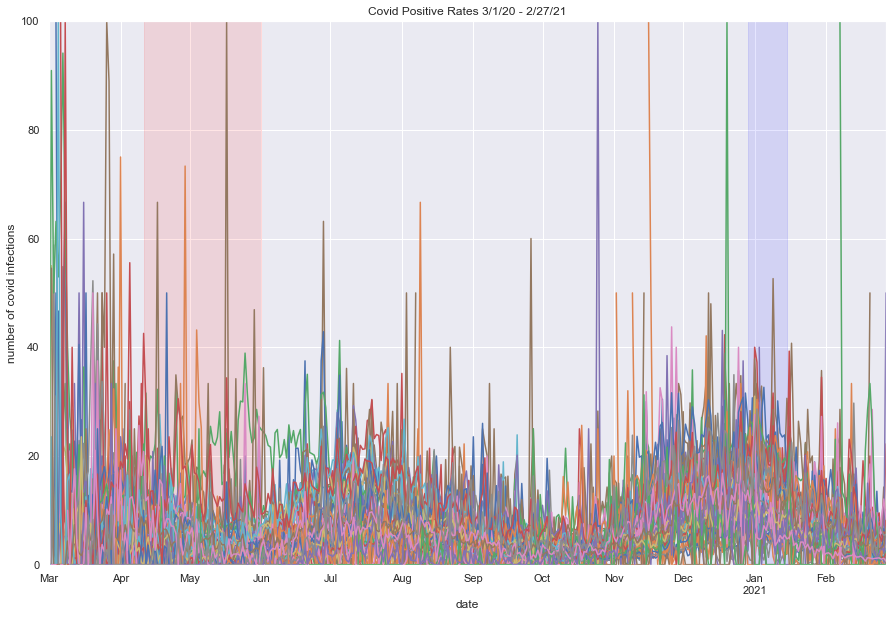

In [54]:
# We need to make this look better
ax = covid_df.pivot(index="date", columns="county", values="rate").plot(figsize=(15, 10))
ax.set_title('Covid Positive Rates 3/1/20 - 2/27/21')
ax.axvspan(dates.datestr2num('2020-04-11'), dates.datestr2num('2020-06-1'), color='red', alpha=0.1)
ax.axvspan(dates.datestr2num('2020-12-29'), dates.datestr2num('2021-01-15'), color='blue', alpha=0.1)
ax.get_legend().remove()
ax.set_ylabel('number of covid infections')
plt.ylim(0, 100)

This is a graph of all the covid positivity rates amongst the counties in California from March 1, 2020 - February 27, 2021. The *red highlight* from April 11, 2020 - June 1, 2020 is when the first stimulus check was disbursed and the *blue highlight* from December 29, 2020 - January 15, 2021 is when the second stimulus check was disbursed. 

Even though the lines are all clumped together at the bottom of the graph due to there being 58 counties in California, we can see that majority of the counties seemed to follow the same trend and the spikes amongst the different counties also appear around the same time. We notice that following the disbursement of the first and second stimulus checks there were decreases in covid positivity rates.

Since this graph is quite messy, let's take a look at the graph with the daily average rates of the counties instead.

(0.0, 100.0)

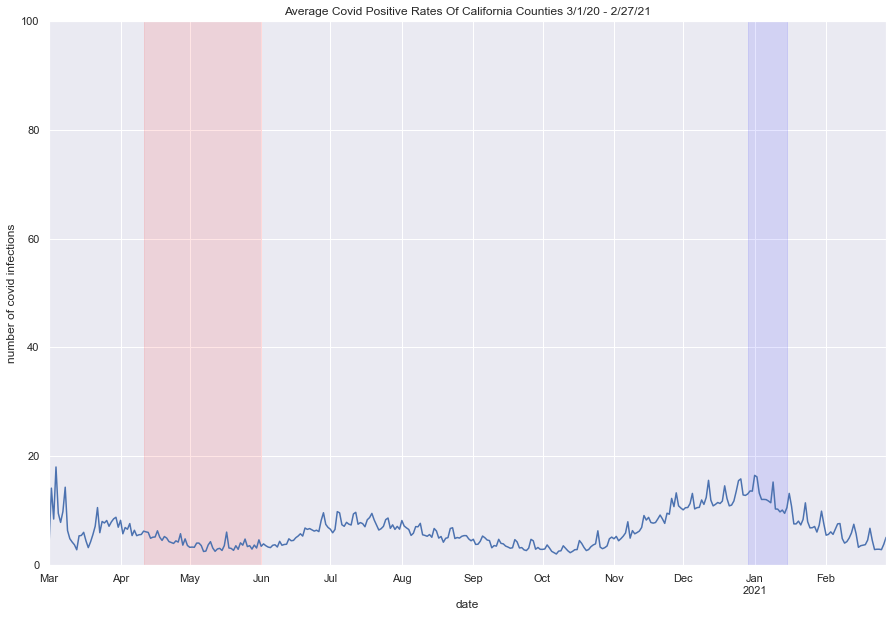

In [44]:
ax = grouped_means.plot(x='date', y='rate', figsize=(15, 10))
ax.set_title('Average Covid Positive Rates Of California Counties 3/1/20 - 2/27/21')
ax.axvspan(dates.datestr2num('2020-04-11'), dates.datestr2num('2020-06-1'), color='red', alpha=0.1)
ax.axvspan(dates.datestr2num('2020-12-29'), dates.datestr2num('2021-01-15'), color='blue', alpha=0.1)
ax.get_legend().remove()
ax.set_ylabel('number of covid infections')
plt.ylim(0, 100)

We notice that the graph with each county as an individual lines seems to have a lot of rates above 20%, but this average graph shows that the average rates is lower than 20% throughout the time period we're looking at.

---

We will then look at the first stimulus check and the second stimulus check separately.

(0.0, 100.0)

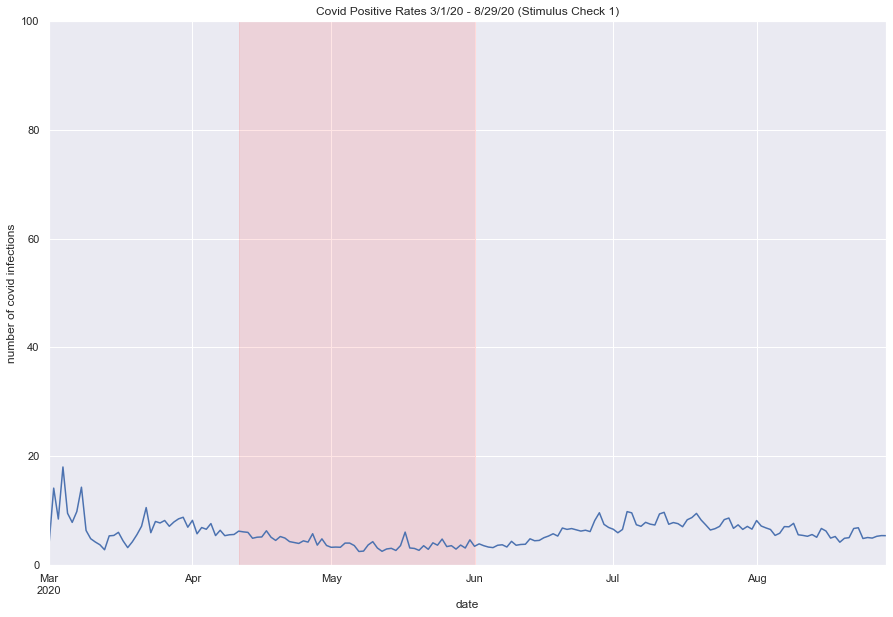

In [47]:
ax = grouped_covid_stim1.plot(x='date', y='rate', figsize=(15, 10))
ax.set_title('Covid Positive Rates 3/1/20 - 8/29/20 (Stimulus Check 1)')
ax.axvspan(dates.datestr2num('2020-04-11'), dates.datestr2num('2020-06-1'), color='red', alpha=0.1)
ax.get_legend().remove()
ax.set_ylabel('number of covid infections')
plt.ylim(0, 100)

This is a graph of a subset of covid rates from March 1, 2020 - August 29, 2020. From this we can more clearly observe that there seems to be a decrease in covid positivity rates after the first stimulus check was disbursed. 

---

(0.0, 100.0)

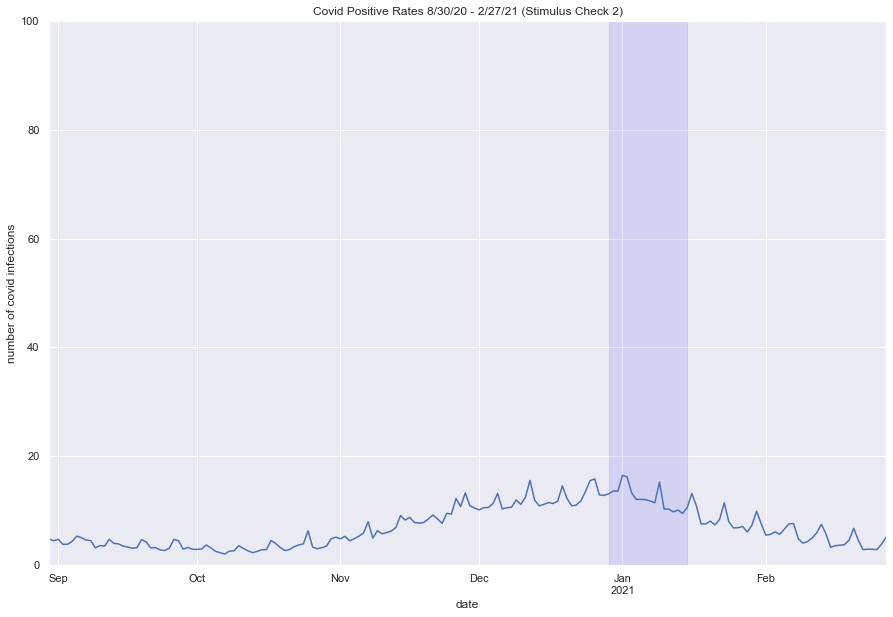

In [48]:
ax = grouped_covid_stim2.plot(x='date', y='rate', figsize=(15, 10))
ax.set_title('Covid Positive Rates 8/30/20 - 2/27/21 (Stimulus Check 2)')
ax.axvspan(dates.datestr2num('2020-12-29'), dates.datestr2num('2021-01-15'), color='blue', alpha=0.1)
ax.get_legend().remove()
ax.set_ylabel('number of covid infections')
plt.ylim(0, 100)

This is a graph of a subset of covid rates from August 30, 2020 - February 27, 2021. From this we can see that there seems to be a downward trend of covid positivity rates from before the second stimulus check was disbursed to after it was disbursed. 

---

In order to compare the covid positivity rates before and after the stimulus checks were disbursed, we narrowed our focus to one month before and one month after the disbursement of stimulus checks. To do this, we created 2 data frames where we have the covid positivity rates a month before and a month after the first stimulus check. We then looked at the distribution of covid positivity rates during these two months separately. We do this same process for the second stimulus check. 

In [11]:
before_stim_1 = covid_df[(covid_df['date'] <= '2020-04-11') & (covid_df['date'] >= '2020-03-11')] 
before_stim_1

after_stim_1 = covid_df[(covid_df['date'] > '2020-04-11') & (covid_df['date'] <= '2020-05-11')]
after_stim_1

before_stim_2 = covid_df[(covid_df['date'] < '2020-12-29') & (covid_df['date'] >= '2020-11-29')]
after_stim_2 = covid_df[(covid_df['date'] >= '2020-12-29') & (covid_df['date'] < '2021-01-29')]

Text(0, 0.5, 'Counts')

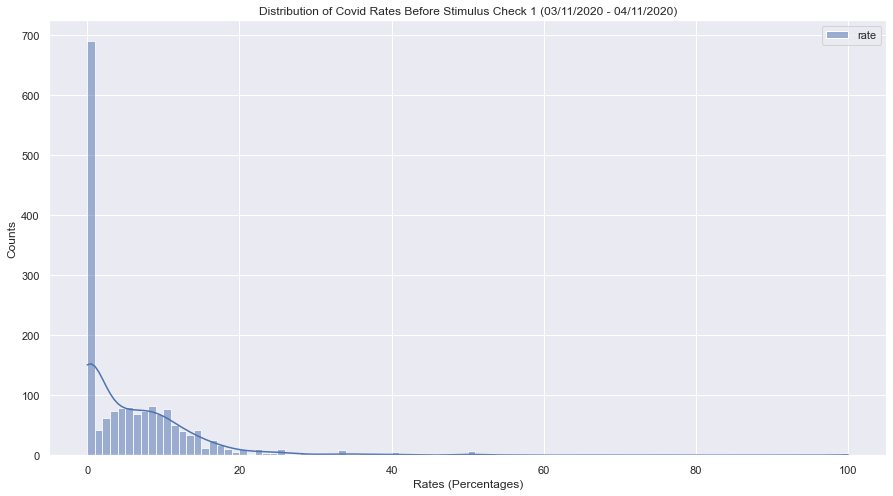

In [12]:
# Histogram before the first stim check
sns.set(rc = {'figure.figsize':(15,8)})

before_stim_1_hist = sns.histplot(before_stim_1, bins = 100, kde = True)

plt.title('Distribution of Covid Rates Before Stimulus Check 1 (03/11/2020 - 04/11/2020)')
plt.xlabel('Rates (Percentages)')
plt.ylabel('Counts')

In [13]:
before_stim_1.describe()

,rate
count,1723.000000
mean,6.253702
std,9.187371
min,0.000000
25%,0.000000
50%,3.846154
75%,9.523810
max,100.000000


Most positive covid positivity rates were 0%, but the mean covid rates are roughly around 6.25%. We also notice that we have a lot of variance in our data which could imply we have a lot of confounds. If there were less variation, we would have a smaller standard deviation. The large variance could also be due to the fact that tests were not accessible to everyone during this period. In other words, there were counties only testing people who were showing symptoms.

--- 

Text(0, 0.5, 'Counts')

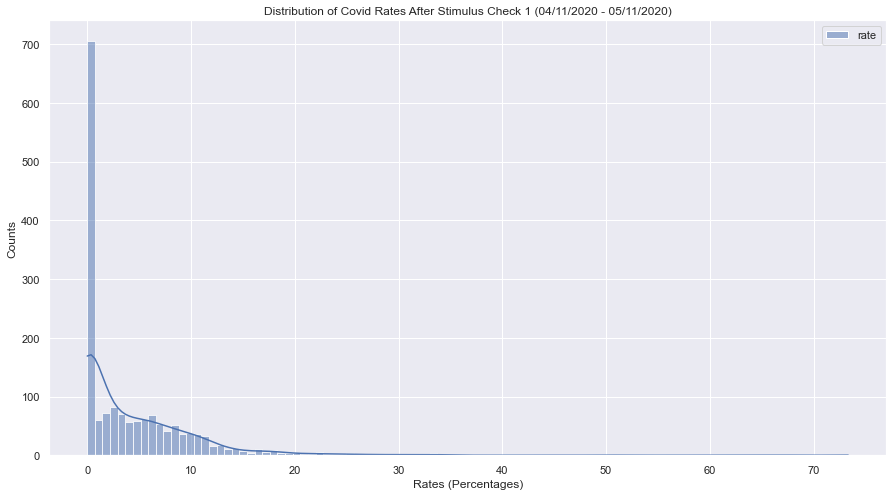

In [14]:
# Histogram after the first stim check
sns.set(rc = {'figure.figsize':(15,8)})

after_stim_1_hist = sns.histplot(after_stim_1, bins = 100, kde = True)

plt.title('Distribution of Covid Rates After Stimulus Check 1 (04/11/2020 - 05/11/2020)')
plt.xlabel('Rates (Percentages)')
plt.ylabel('Counts')

In [15]:
after_stim_1.describe()

,rate
count,1661.000000
mean,4.261875
std,6.080804
min,0.000000
25%,0.000000
50%,2.083333
75%,6.707317
max,73.333333


Here we see that after the first stimulus check, the mean covid positivity rates went from 6.25% to 4.26% and the median went from 3.85% to 2.08% which *could* imply that the decrease in covid infection rates was due to the stimulus check. We also note that the standard deviation decreased from 9.18% to 6.08%.

---

Text(0, 0.5, 'Counts')

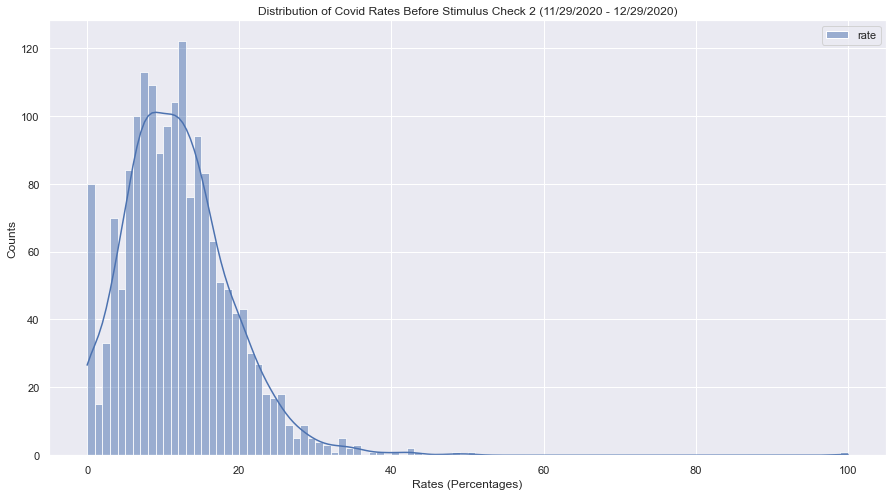

In [16]:
# Histogram before the second stim check
sns.set(rc = {'figure.figsize':(15,8)})

before_stim_2_hist = sns.histplot(before_stim_2, bins = 100, kde = True)

plt.title('Distribution of Covid Rates Before Stimulus Check 2 (11/29/2020 - 12/29/2020)')
plt.xlabel('Rates (Percentages)')
plt.ylabel('Counts')

In [17]:
before_stim_2.describe()

,rate
count,1731.000000
mean,11.910934
std,7.267595
min,0.000000
25%,7.017074
50%,11.203917
75%,15.810544
max,100.000000


During this time period which is approximately 6 months later, we see that the mean covid rate increased to 11.91% as well as an slight increase in the standard deviation being 7.26%. This *could* be that people might have ran out of their stimulus money, so covid rates *potentially* increased in that 6 month period; however, there could be confounding variables (will be discussed in conclusion). Also, we noticed the distrubution is starting to look more like a normal distribution, most likely due to covid tests becoming more common and easily accessible.

Text(0, 0.5, 'Counts')

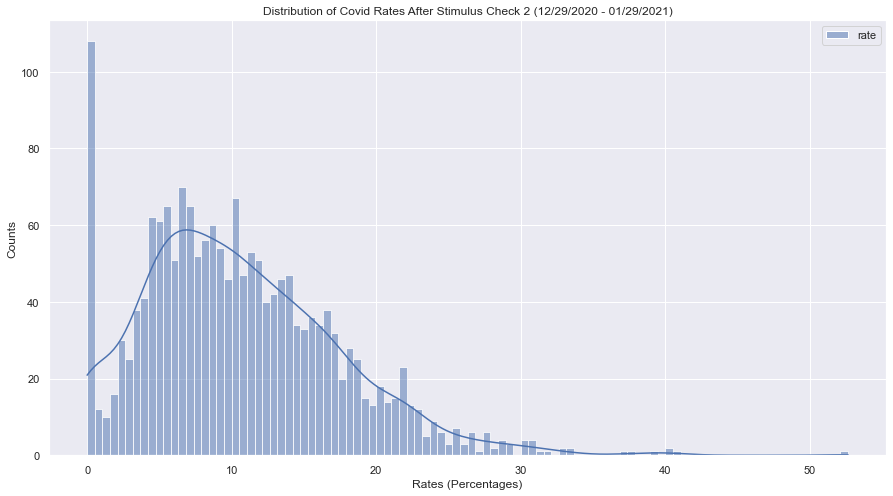

In [18]:
# Histogram after the second stim check
sns.set(rc = {'figure.figsize':(15,8)})

after_stim_2_hist = sns.histplot(after_stim_2, bins = 100, kde = True)

plt.title('Distribution of Covid Rates After Stimulus Check 2 (12/29/2020 - 01/29/2021)')
plt.xlabel('Rates (Percentages)')
plt.ylabel('Counts')

In [19]:
after_stim_2.describe()

,rate
count,1794.000000
mean,10.601689
std,6.809880
min,0.000000
25%,5.695840
50%,9.681470
75%,14.683873
max,52.631579


After the second stimulus check, we notice that the mean covid positivity rate still remained high and only decreased slightly to 10.6%; however, the standard deviation decreased to 6.8% which implies the covid rates are not varying as much. In other words, the covid rates are stabilizing. The reason that covid rates might be high could be due to the holiday season which will be discussed in the conclusion section.

### Running 1 Sample Z-Test
---

We wanted to compare the means from the before and after to see if there was a change in covid positivity rates. Since we are including all the counties in California, we are using the population mean instead of a sample mean. Therefore, a z-test is more appropriate than a t-test for our analysis.

Since our sample size is bigger than 30, we can assume that the distribution is approximately normal. The z-test is used to determine if there is a significant difference between the means of two groups, which is appropriate for our analysis as we are comparing the mean covid positivity rate pre and post stimulus checks.

If the mean covid rates before the stimulus check is significantly different than the mean after the stimulus check, then this could imply that there is a relationship between stimulus checks and covid positivity rates. 

If the means were the same or similiar (p >= 0.05), that could imply that the stimulus check did not have an affect on the covid positivity rates, therefore we would fail to reject the null hypothesis. 

### We are running the 1 sample z-test on the the before and after covid rates of the first stimulus check. 

In [20]:
before_stim_1_rates = np.array(before_stim_1['rate'])
before_stim_1_rates

after_stim_1_rates = np.array(after_stim_1['rate'])
test_stat_1, p_val_1 = ztest(after_stim_1_rates, value = np.mean(before_stim_1_rates))
print('z test: ', test_stat_1)
print('p value: ', p_val_1)

z test:  -13.349824335904255
p value:  1.1872856617495432e-40


We see the p-value is << 0.05 which means we reject our null hypothesis. This implies that there could be a relationship between covid rates and stimulus checks.

We see that the mean covid positivity rate during the month after the first stimulus check is 13 standard deviations below the mean covid rates one month before the first stimulus check, which means there was a decrease in covid rates after the first stimulus check. 

---

### We now want to run the same test with the second stimulus check

In [21]:
before_stim_2_rates = np.array(before_stim_2['rate'])
before_stim_2_rates

after_stim_2_rates = np.array(after_stim_2['rate'])
test_stat_2, p_val_2 = ztest(after_stim_2_rates, value = np.mean(before_stim_2_rates))
print('z test: ', test_stat_2)
print('p value: ', p_val_2)

z test:  -8.143150271069839
p value:  3.851237958247626e-16


We again see the p-value is << 0.05 which means we reject our null hypothesis. This also implies that there could be a relationship between covid rates and stimulus checks.

We see that the mean covid positivity rate during the month after the second stimulus check is 8 standard deviations below the mean covid rates one month before the second stimulus check which means there was a decrease in covid rates after the second stimulus check was given. 

# Ethics & Privacy

There are no privacy and terms of use issues because we used publicly available data from the government that do not contain any personal identifiable information. Therefore, we ethically obtained our data. Our dataset contained daily positive covid rates for each county in California, and the stimulus check amounts. In terms of the way data was collected for covid tests, there was no bias because all tests were reported at the time the tests were taken. Moreover, the *Families First Coronavirus Response Act*, which was signed into law on March 18, 2020, mandated that COVID-19 tests be free to anyone, regardless if they're insured or not. Hence, covid tests were accessible to many, i.e. no bias. However, stimulus checks were only given to specific people, in other words, some weren't eligible for receiving a stimulus check. For example, high-wage earners and the people that didn't file taxes didn't recieve stimulus checks. So, there is some bias introduced for this part of our dataset. Now, for our visualizations and analysis, since we considered all counties in California, there is no bias for this part. 

# Conclusion & Discussion

We started by asking the question of whether there is a relationship between stimulus checks and positive covid rates in California counties. We aimed to answer this question using a dataset containing daily positive covid rates for each county in California between March 2020 to February 2021, and the periods of which the first and second stimulus checks were disbursed. We created line graphs to show the trends of positive covid rates for each county in California from March 2020 to February 2021. We then used two z-tests, one comparing the mean of positive covid rates a month before and after the first stimulus check disbursement period, and the other comparing the mean of positive covid rates a month before and after the second stimulus check disbursement period. We ended up rejecting the null hypothesis for both since the p-value that we obtained was very small (way less than 0.05). Even though our results from our z-tests showed that there was a significant decrease in positive covid rates after each of the first two stimulus checks were disbursed (due to having large negative z scores), this does not mean that there is a relationship between stimulus checks and positive covid rates because there are a lot of confounding variables that we will discuss below. Also, there were a lot of tests and analyses we could not do because we did not have the needed data. 
- Why we couldn't run other tests: 
    - We couldn't look at the correlation between stimulus checks and positive covid rates because finding correlation requires two variables, one for stimulus checks and one for covid rates, but we only have covid rates. For our current datasets, the only way we can vary the stimulus checks is by the different amount of money that was given for each of the different stimulus checks. However, that is only two values (three if we also consider the third stimulus check). Moreover, finding the correlation between the two or three stimulus checks and the covid rates, does not really offer much insight because there would only be two or three points on the graph. Another way is to find the correlation between households who received different amounts of stimulus money (due to having different household sizes) and their covid rates. However, there is no such dataset.
    - why we couldn't do inferential (idk how to spell...)
    - why we couldn't do *insert test* 
- Confounds
    - The covid pandemic is really unpredictable since there are a lot of different factors that can affect positive covid rates.
    - Different variances.
    - The first covid shot was available in December 2020, which was around the same time the second stimulus check was disbursed. Therefore, the covid vaccine could have contributed to the decrease in positive covid rates after the disbursement of the second stimulus check.
    - After the first stimulus check was disbursed, we were put on a lock down for the next 6-8 months, so quarantine likely had an effect on the decrease in covid positivity rates.
    - People used their stimulus checks differently: Some used their stimulus checks to pay for necessity goods (e.g. food, water, utilities), whereas others have used it for other things like building new computers that did not influence them to stay at home. (?)
    - Holidays could have also led to an increase in positive covid rates since there are more gatherings during holidays such as Thanksgiving, Christmas, and New year's, which occured right before or during the second stimulus check disbursement. So, even though positive covid rates decreased after the second stimulus check disbursement, it could have just been because there were less gatherings considering holiday season was over, and not because stimulus checks caused people to have the ability to stay at home longer.
    - People got tired of lock down in the later half
- Data set issues (couldn't find the right data sets) 
    - We wanted costs of living for each county in California 
        - intended to group by people and groups based on costs of living. The same amount of money in one county could be less/more impactful than another county. 
        - Having this data could have allowed us to go deeper into our analysis by recognizing any possible patterns that could have shown up between counties that have a higher cost of living and counties that have a lower cost of living. For example, a possible pattern could have been that generally, counties with high cost of living did not have a decrease in positive covid rates after the stimulus check disbursement.
    - Total amount of money each county got 
        - potentially could have helped for sampling purposes. Compare other counties
    - First idea was to compare the amount of stimulus money amongst different groups, but everyone got the same amount of money, so this dataset didn't exist. 
    - Overall, we lacked a lot of resources to run different tests and analysis. Having more variety of data sets would have potentially helped with confounding variables. However, since we didn't have them, we will never really know how our analysis and results could have looked like. 


# Team Contributions

*Specify who in your group worked on which parts of the project.*